In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# tensorflow imports
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission, select_day_nums
from evaluation import Referee, RapidReferee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern, AggregateAgent
from train import BatchCreator, Logger, make_loss

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Top Down for M5Forecast - Accuracy - Visualisation
This notebook investigates the Top Down approach for the M5Forecast - Accuracy challenge. Here, the aggregated sales of the stores are predicted directly by the model, instead of calculating the sales by aggregating product-level predictions. To test the performance of the agents created in `top-down-stores-wrmsse-loss.ipynb` the predictions are compared to the true sales. 

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=10, train_size=-1)

# create referee for fold 10
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
def preprocess(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    # prices and calendar inputs are for compatibility
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Normalize
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    return df, norm

In [6]:
# Get suitable train df
train_df, train_norm = preprocess(sales_train)
features = train_df.columns

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=features, 
                             window_in=window_in, window_out=window_out)

# Test if batch creator works
x, y = next(batch_creator.flow())
print("Input shape: {}, output shape: {}".format(x.shape, y.shape))
batch_creator.on_epoch_end()  # reset generator

Input shape: (32, 28, 10), output shape: (32, 28, 10)


In [7]:
def get_model(inp_shape, out_shape, loss='MSE'):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp = Input(shape=inp_shape, name="input")
    x = Reshape((np.prod(inp_shape), 1))(inp)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation='relu')(x)

    out = Conv1D(1, kernel_size=1, activation='linear', name='output')(x)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=loss, optimizer='adam', metrics=['MSE', loss])
    
    return model

model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

In [8]:
model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels),
                  loss=make_loss(ref, train_norm=train_norm))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

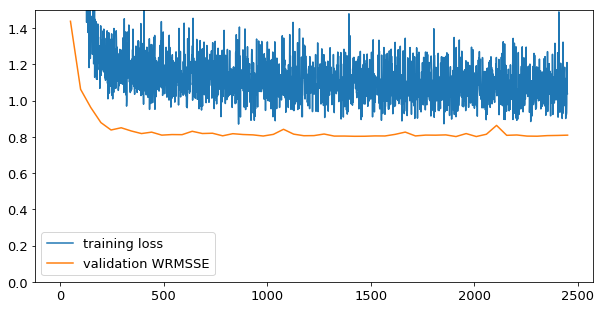

49/49 [==============================] - 6s 118ms/step - loss: 1.0739 - MSE: 0.0028 - WRMSSE_store: 1.0739


In [9]:
agent = AggregateAgent(model=model, train_norm=train_norm, features=features, labels=features, window_in=28)

logger = Logger(ref=ref, cv_generator=cv_generator, train_norm=train_norm, features=features, labels=features,
                agent=agent, preprocess_func=preprocess, folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

In [10]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

Mean WRMSSE level 3: 0.8092662491267602


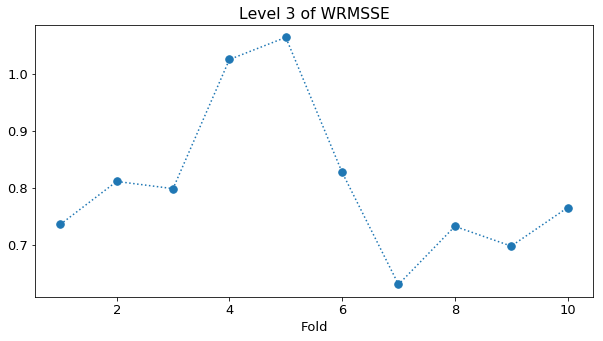

In [11]:
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

## Predict and combine final 10 folds

In [12]:
ls_sales_pred = []
ls_sales_true = []

for fold in logger.folds:
    sales_train, sales_true = cv_generator.get_train_val_split(fold=fold, train_size=agent.window_in)

    sales_true_aggregated = sales_true.groupby(['store_id']).sum()
    train_df, norm = logger.preprocess_func(sales_train, prices=logger.prices,
                                          calendar=logger.calendar, norm=logger.train_norm)

    # select days to predict
    val_day_nums = select_day_nums(sales_true_aggregated)
    sales_pred = agent.predict(train_df, val_day_nums)
    
    ls_sales_pred.append(sales_pred)
    ls_sales_true.append(sales_true_aggregated.T)

In [13]:
sales_pred = pd.concat(ls_sales_pred[::-1])
sales_pred.describe()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,4422.815430,3728.221680,6156.583008,2428.065918,3163.610596,3855.367920,3680.782227,3520.729492,4335.662598,3537.050781
std,703.634094,688.935303,842.011292,314.250641,473.303711,519.470642,435.857605,645.796875,701.344421,568.959656
min,2284.492920,2384.696289,3994.833984,1566.781128,2351.846436,2367.988525,2363.267578,1638.578735,1924.200684,2261.373047
25%,3929.671387,3213.965393,5516.924316,2197.364136,2813.775513,3466.639404,3346.320190,3043.163940,3817.904480,3104.897827
50%,4243.532715,3472.735596,6016.962891,2351.020508,3019.899048,3713.792236,3640.400391,3305.625854,4297.959961,3418.721191
75%,4914.323242,4235.574951,6721.728394,2618.347351,3508.149902,4229.010742,3988.283875,4012.307312,4840.651245,3906.370117
max,6487.624512,5463.145508,8370.674805,3300.488281,4319.406250,5197.671875,4655.549316,5515.835449,6196.809082,5263.654785


In [14]:
sales_true = pd.concat(ls_sales_true[::-1])
sales_true.describe()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,4391.592857,4107.971429,6242.042857,2474.067857,3141.271429,3859.896429,3709.828571,3604.889286,4587.303571,3605.428571
std,941.740152,1065.866184,1091.937185,343.960268,557.490194,666.948500,568.960045,849.013506,1024.401014,766.709290
min,0.000000,2.000000,4.000000,0.000000,1.000000,0.000000,3.000000,2.000000,1.000000,1.000000
25%,3768.000000,3327.250000,5479.500000,2251.750000,2754.000000,3381.000000,3317.250000,3017.750000,3848.500000,3043.750000
50%,4080.000000,3645.500000,6021.000000,2453.000000,3017.000000,3739.000000,3651.000000,3361.500000,4513.000000,3464.500000
75%,5092.500000,5016.250000,6861.500000,2672.500000,3515.000000,4302.000000,4105.250000,4179.250000,5286.250000,4071.500000
max,6829.000000,6542.000000,8979.000000,3343.000000,4589.000000,5479.000000,4929.000000,6182.000000,7852.000000,5666.000000


## Weekly pattern

In [15]:
col_list = []
col_names = []

for i in range(1, 1+7):
    # select days from a certain day of the week
    cols = list(calendar[calendar.wday == i].d.values)
    col_name = calendar[calendar.wday == i].weekday.values[0]
    # filter days to match training set
    cols = [d for d in cols if d in sales_true.index]
    col_list.append(cols); col_names.append(col_name)
    print("{} is day nr. {} of the week".format(col_name, i))

Saturday is day nr. 1 of the week
Sunday is day nr. 2 of the week
Monday is day nr. 3 of the week
Tuesday is day nr. 4 of the week
Wednesday is day nr. 5 of the week
Thursday is day nr. 6 of the week
Friday is day nr. 7 of the week


In [16]:
num_sales_pred = [sales_pred.loc[cols].sum().sum() for cols in col_list]
num_sales_true = [sales_true.loc[cols].sum().sum() for cols in col_list]

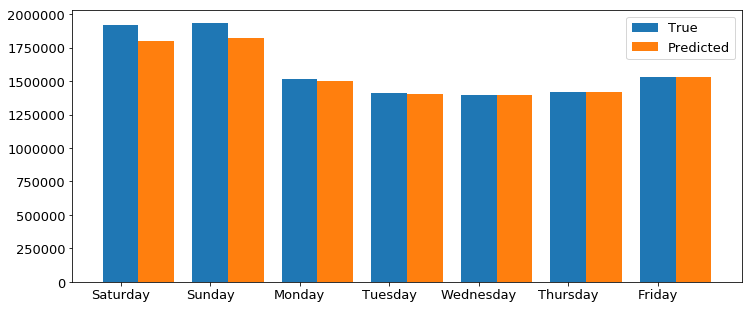

In [17]:
x = np.arange(len(col_names))
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x, height=num_sales_true, width=0.4, label="True")
ax.bar(x+0.4, height=num_sales_pred, width=0.4, label="Predicted")
ax.set_xticks(x); ax.set_xticklabels(col_names)
ax.legend()
plt.show()

**Result**: Even **without** providing information about which day of the week is provided/predicted, the same weekly pattern is present in the predictions! This means that the algorithm is able to learn this pattern, and detect which days are to be predicted!

## Line plot

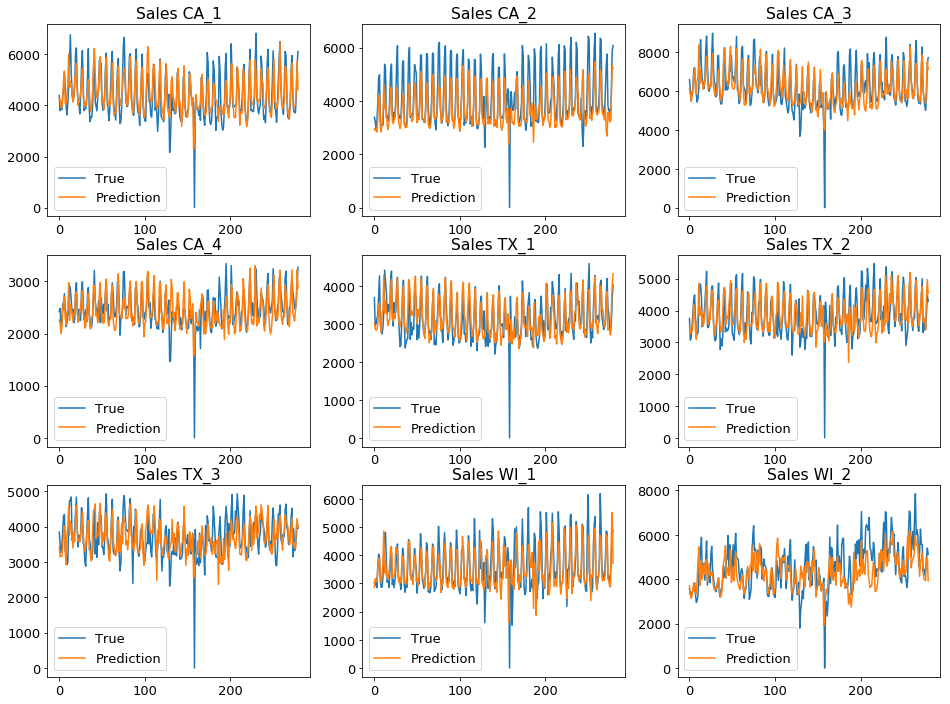

In [19]:
f, axes = plt.subplots(3, 3, figsize=(16, 12))
for i, ax in enumerate(np.ravel(axes)):
    ax.plot(sales_true.iloc[:, i].values, label="True")
    ax.plot(sales_pred.iloc[:, i].values, label="Prediction")
    ax.set_title("Sales {}".format(sales_true.columns[i]))
    ax.legend()

plt.show()

The network seems to be more conservative in the deviation from the mean in its predictions, and Christmas is not helping. 

## Events

nan
SuperBowl


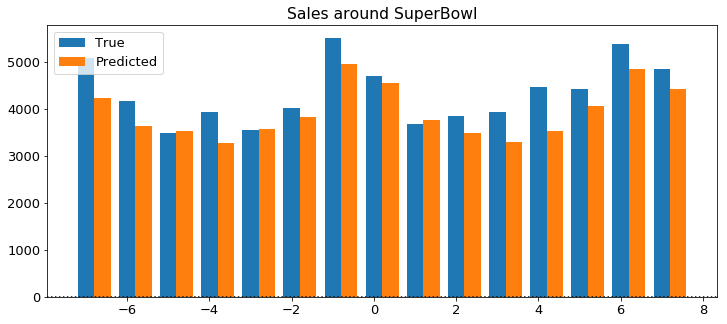

ValentinesDay


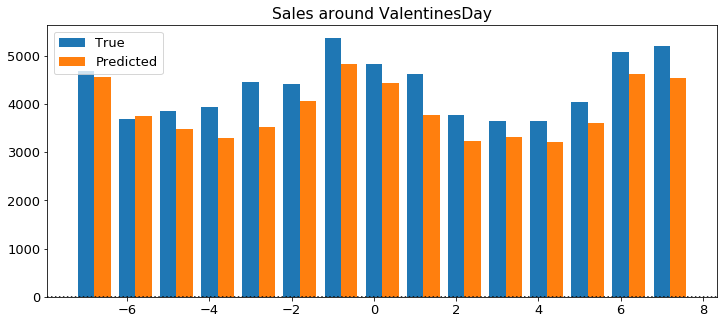

PresidentsDay


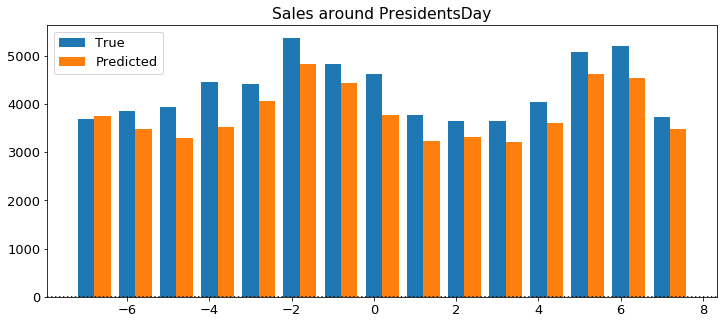

LentStart


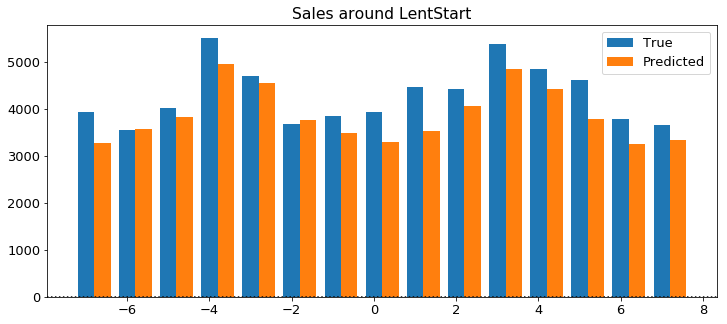

LentWeek2


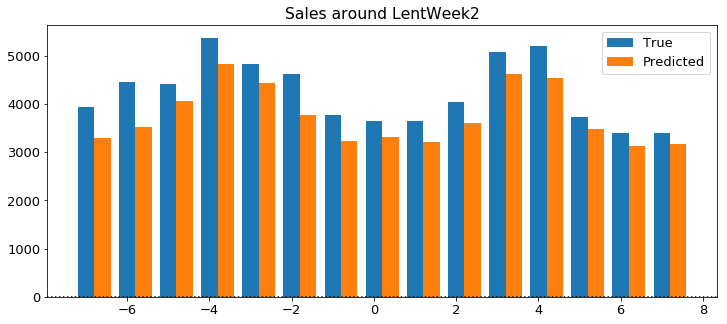

StPatricksDay


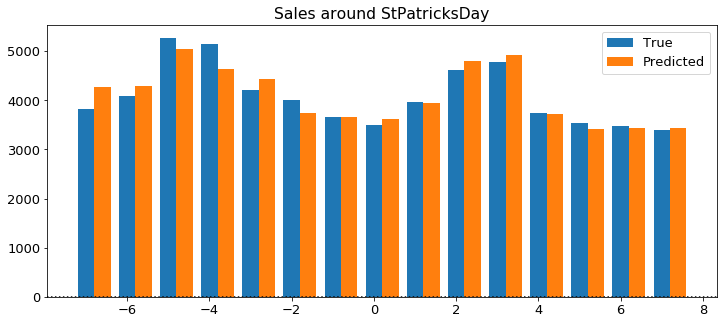

Purim End


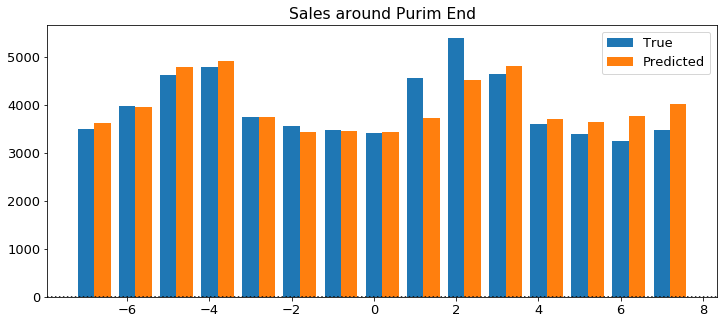

OrthodoxEaster
Pesach End
Cinco De Mayo
Mother's day
MemorialDay
NBAFinalsStart
NBAFinalsEnd
Father's day
IndependenceDay
Ramadan starts
Eid al-Fitr
LaborDay


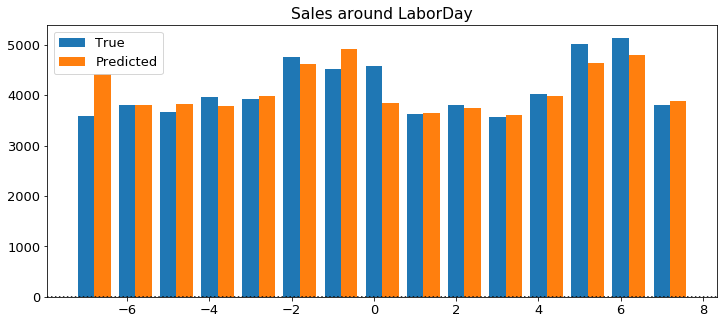

ColumbusDay


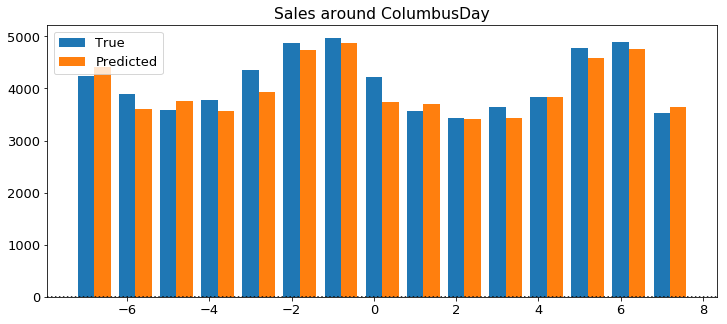

Halloween


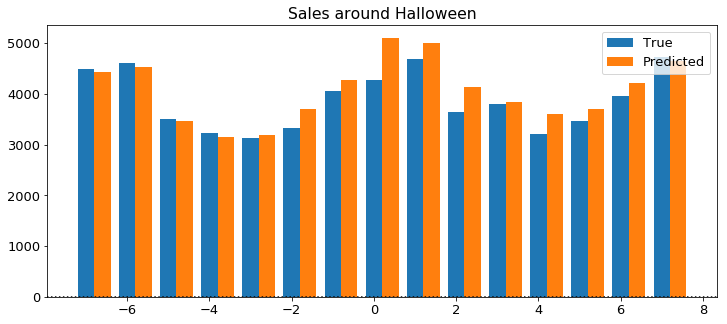

EidAlAdha


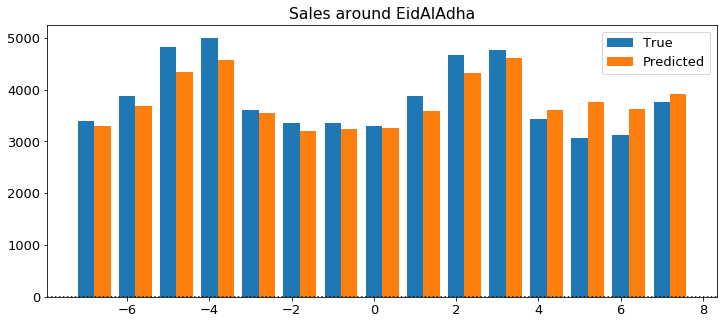

VeteransDay


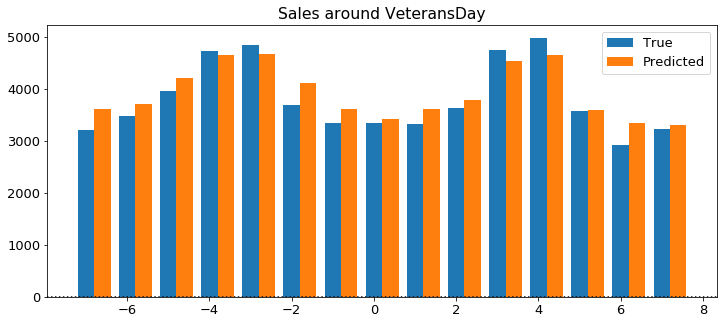

Thanksgiving


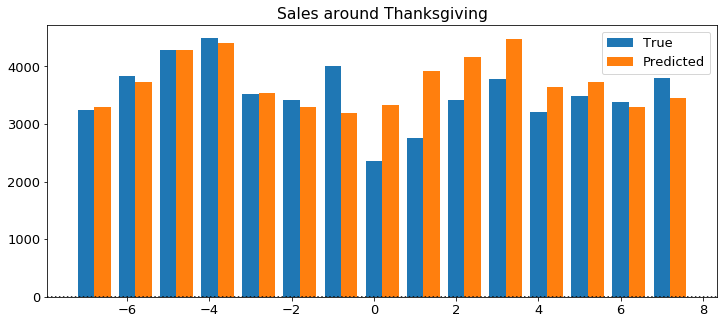

Christmas


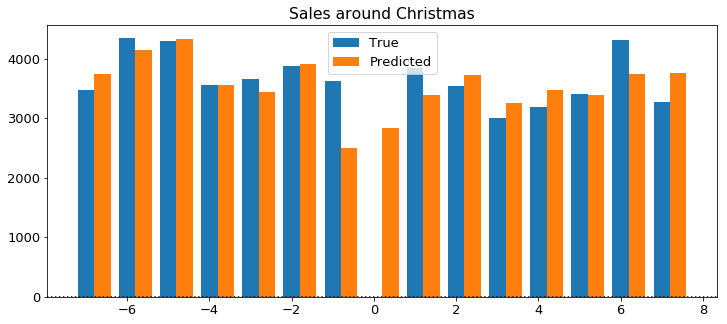

Chanukah End


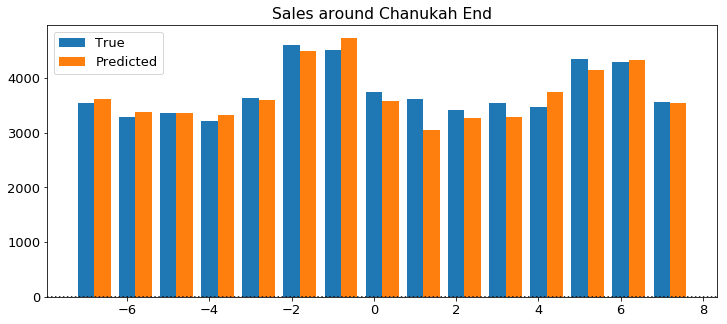

NewYear


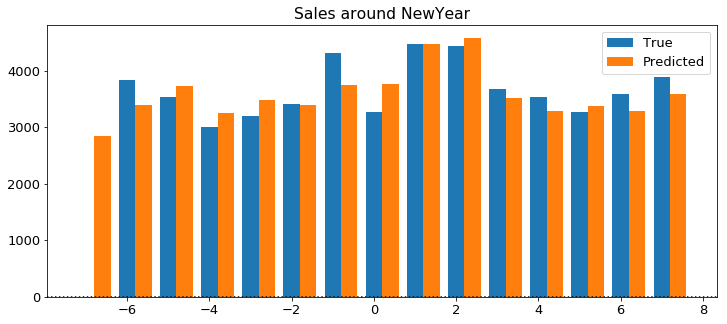

OrthodoxChristmas


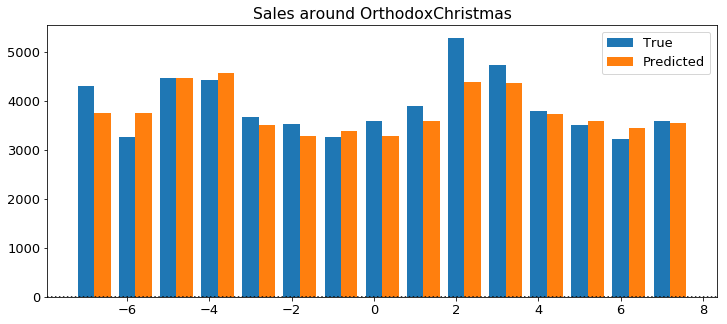

MartinLutherKingDay


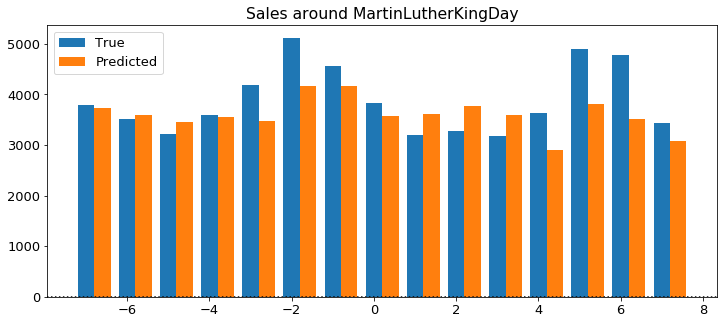

Easter


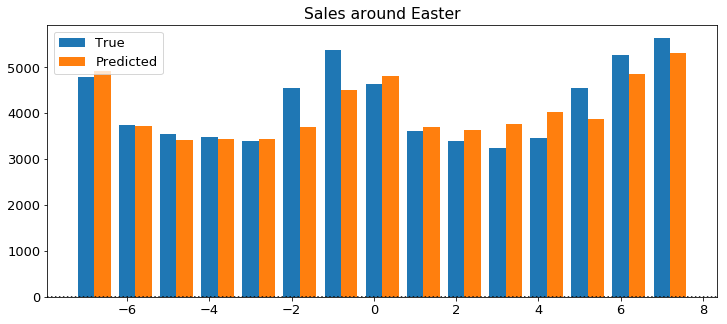

In [23]:
for event_name in calendar.event_name_1.unique():
    print(event_name)
    # select days with that event
    day_list = list(calendar[calendar.event_name_1 == event_name].d)
    day_list = [d for d in day_list if d in sales.index]
    # convert to array of integers
    day_list = np.array([int(col[2:]) for col in day_list])
    
    if len(day_list) == 0:
        continue
    
    # calculate sales prior and after event
    sales_prior_true, sales_after_true = [], []
    sales_prior_pred, sales_after_pred = [], []
    for i in range(1, 1+7):
        # sales prior
        d_ls = ['d_%d'%(d-i) for d in day_list]
        sales_prior_true.append( sales_true.loc[d_ls].mean().mean() )
        sales_prior_pred.append( sales_pred.loc[d_ls].mean().mean() )
        
        # sales after
        d_ls = ['d_%d'%(d+i) for d in day_list]
        sales_after_true.append( sales_true.loc[d_ls].mean().mean() )
        sales_after_pred.append( sales_pred.loc[d_ls].mean().mean() )
    
    # calculate sales at event
    d_ls = ['d_%d'%d for d in day_list]
    sales_event_true = sales_true.loc[d_ls].mean().mean()
    sales_event_pred = sales_pred.loc[d_ls].mean().mean()
    
    # plot sales
    x_prior = -1 - np.arange(len(sales_prior))
    x_after = 1 + np.arange(len(sales_after))

    f, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.axhline(1, linestyle=':', color='k')
    # True sales
    ax.bar(x_prior, height=sales_prior_true, width=0.4, color="C0", label="True")
    ax.bar(0, height=sales_event_true, width=0.4, color="C0")
    ax.bar(x_after, height=sales_after_true, width=0.4, color="C0")
    # Predicted sales
    ax.bar(x_prior+0.4, height=sales_prior_pred, width=0.4, color="C1", label="Predicted")
    ax.bar(0.4, height=sales_event_pred, width=0.4, color="C1")
    ax.bar(x_after+0.4, height=sales_after_pred, width=0.4, color="C1")
    
    ax.set_title("Sales around {}".format(event_name))
    ax.legend()
    plt.show()